In [2]:
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pandas.tools.plotting import parallel_coordinates
import pandas as pd
from sklearn import svm

from sklearn.metrics import jaccard_similarity_score

#from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

random_state = 100
#import xgboost as xgb

import pickle
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.model_selection import cross_val_score

In [3]:
#IMPORT DATA
data = pickle.load( open( "data/initial_features.pkl", "rb" ))
labels = pickle.load(open("data/initial_labels.pkl", "rb"))

#X = data.values
#y = labels.values

In [4]:
# create training and testing vars
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.3)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(5338, 14) (5338, 1)
(2288, 14) (2288, 1)


In [4]:
#CV SVM train
#clf = svm.SVC(kernel='linear', C=100)
#scores = cross_val_score(clf, X_train, np.ravel(Y_train), cv=10)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#scores = np.dot(X_train, clf.coef_.T)
#b0 = Y_train==0 # boolean or "mask" index arrays
#b1 = Y_train==1
#malignant_scores = scores[b1]
#benign_scores = scores[b0]

#fig  = plt.figure()
#fig.suptitle("score breakdown by classification", fontsize=14, fontweight='bold')
#score_box_plt = plt.boxplot(
#    [malignant_scores, benign_scores],
#    notch=True,
#    labels=[0,1],
#    vert=False
#)
#plt.show(score_box_plt)   

### SVM

/Users/manolis/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


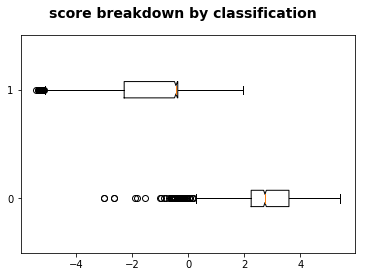

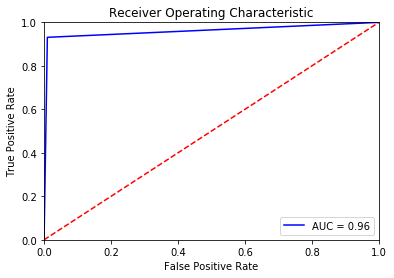

In [11]:
lin_clf = svm.SVC(kernel='linear')
lin_clf.fit(X_train,Y_train)

scores = np.dot(X_train, lin_clf.coef_.T)

b0 = Y_train==0 # boolean or "mask" index arrays
b1 = Y_train==1
malignant_scores = scores[b1]
benign_scores = scores[b0]

fig  = plt.figure()
fig.suptitle("score breakdown by classification", fontsize=14, fontweight='bold')
score_box_plt = plt.boxplot(
    [malignant_scores, benign_scores],
    notch=True,
    labels=[0,1],
    vert=False
)
plt.show(score_box_plt) 

# get the predictions
probas_ = lin_clf.predict(X_test)
            
# turn the predictions into correct format
probas_ = np.array([(1-x, x) for x in probas_])

# create roc curve
probs = lin_clf.predict(X_test)
preds = probs
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Get contributing features on (SVM) classification for a selected example

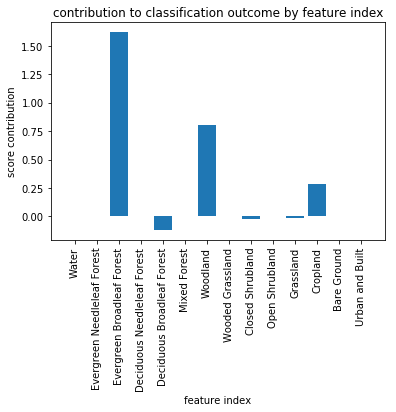

Sorted features by max value :


[('Evergreen Broadleaf Forest', 1.6184684241235767),
 ('Woodland', 0.8032893706724775),
 ('Cropland', 0.28305972290994635),
 ('Wooded Grassland', 0.0),
 ('Bare Ground', -0.0),
 ('Urban and Built', -0.0),
 ('Deciduous Needleleaf Forest', -0.0),
 ('Mixed Forest', -0.0),
 ('Water', 0.0),
 ('Open Shrubland', -0.0),
 ('Evergreen Needleleaf Forest', -0.0),
 ('Grassland', -0.009107123113590607),
 ('Closed Shrubland', -0.020653848226125135),
 ('Deciduous Broadleaf Forest', -0.11903441380065977)]

In [33]:

selected_example = data.values[3]

lin_clf.predict(selected_example.reshape(1,14))

contributions = np.multiply(selected_example, lin_clf.coef_.reshape((14,)))
feature_number = np.arange(len(contributions)) +1

features_coefficients = dict(zip(list(data), contributions))
#print(features_coefficients)

plt.bar(list(data), contributions, align='center')
plt.xticks(list(data), rotation='vertical')
plt.xlabel('feature index')
plt.ylabel('score contribution')
plt.title('contribution to classification outcome by feature index')
plt.show()

# Sort features

#abs_contributions = np.flip(np.sort(np.absolute(contributions)), axis=0)
#feat_and_contrib = []
#for contrib in abs_contributions:
#    if contrib not in contributions:
#        contrib = -contrib
#        feat = np.where(contributions == contrib)
#        feat_and_contrib.append((feat[0][0], contrib))
#    else:
#        feat = np.where(contributions == contrib)
#        feat_and_contrib.append((feat[0][0], contrib))

# sorted by max abs value. each row a tuple:;(feature index, contrib)
print("Sorted features by max value :")
#feat_and_contrib
sorted(features_coefficients.items(), key=lambda t: t[1], reverse=True)

#### SVM Stratified k-fold (k = 10)

In [26]:

scores = []
XX, YY = X_train, Y_train
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)
#print(XX.iloc[50])
for train_index, test_index in skf.split(XX, YY):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_ttrain, X_ttest = XX.iloc[train_index], XX.iloc[test_index]
    y_ttrain, y_ttest = YY.iloc[train_index], YY.iloc[test_index]
    svm_test = svm.SVC(kernel='linear')
    svm_test.fit(X_ttrain,np.ravel(y_ttrain))
    
    # get the predictions
    probas_ = svm_test.predict(X_ttest)
            
    # turn the predictions into correct format
    probas_ = np.array([(1-x, x) for x in probas_])

    # create roc curve
    probs = svm_test.predict(X_ttest)
    preds = probs
    fpr, tpr, threshold = metrics.roc_curve(np.ravel(y_ttest), preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    print("AUC: "+str(roc_auc))
    scores.append(roc_auc)
print("The mean value of the scores is: ", np.mean(scores))

AUC: 0.9500944159697869
AUC: 0.9587117465455745
AUC: 0.9505365224949794
AUC: 0.9577922077922078
AUC: 0.9380411255411256
AUC: 0.9752311457577955
AUC: 0.9824072395455644
AUC: 0.9538766014019823
AUC: 0.9483623398598018
AUC: 0.9509004109257917
The mean value of the scores is:  0.956595375583461


# Random Forest

In [9]:
# Hyperparameter Optimization for random forest
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from time import time

# initialize the classifier
clf_RF = RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=100)

# find the number of features for parameter optimization
num_features = X_train.shape[1]

# make scorer
auc_scorer = make_scorer(roc_auc_score, needs_threshold=True)#, needs_proba=True

# params
m_depths = [None] + list(range(2, 21, 3))

# specify parameters and distributions to sample from
param_dist_rf = {"max_depth": m_depths, # [None, 2, 5, 8, 11, 14, 17, 20]
                 "max_features": sp_randint(1, num_features),
                 "min_samples_split": sp_randint(2, 100),
                 "min_samples_leaf": sp_randint(1, 100),
                 "bootstrap": [True, False],
                 "criterion": ["gini", "entropy"]}

n_iter_search = 30 # was 20

# run randomized search
random_search_RF = RandomizedSearchCV(clf_RF, 
                                      param_distributions=param_dist_rf,
                                      n_iter=n_iter_search,
                                      scoring=auc_scorer,
                                      random_state=random_state,
                                      n_jobs=-1,
                                      return_train_score=True)

start = time()
random_search_RF.fit(X_train, Y_train)
print("RandomizedSearchCV took {:.2f} seconds for {} candidates"
      " parameter settings.\n".format((time() - start), n_iter_search))

# display the dataframe without the parameters column for better rendering
display(pd.DataFrame(random_search_RF.cv_results_).drop('params', axis=1))

best_parameters_RF = pd.Series(random_search_RF.best_params_)

# display the best set of parameters
display(best_parameters_RF)


/Users/manolis/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/manolis/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV took 303.58 seconds for 30 candidates parameter settings.



,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,9.800942,0.821022,0.984401,0.985962,True,gini,8,8,88,81,...,0.984613,0.986736,0.984333,0.985392,0.984256,0.985757,0.244994,0.004158,0.000154,0.000568
1,7.273871,0.864646,0.982480,0.984069,True,gini,17,5,99,55,...,0.983766,0.985184,0.981401,0.983706,0.982272,0.983317,0.247096,0.046607,0.000977,0.000804
2,7.232033,0.793218,0.992013,0.993975,True,gini,17,3,25,17,...,0.990829,0.994680,0.992311,0.993406,0.992899,0.993838,0.549288,0.048204,0.000871,0.000529
3,14.186335,0.838521,0.995043,0.996957,True,entropy,11,11,17,11,...,0.993791,0.997389,0.996298,0.996605,0.995040,0.996879,1.476162,0.006171,0.001023,0.000325
4,16.221230,0.766120,0.991174,0.994323,False,gini,5,12,5,33,...,0.991931,0.995085,0.992861,0.993838,0.988730,0.994046,0.289703,0.049904,0.001770,0.000546
5,12.264140,0.863413,0.995256,0.997182,False,entropy,14,4,5,93,...,0.994029,0.997425,0.996377,0.996780,0.995364,0.997340,1.522601,0.046708,0.000962,0.000286
6,8.485361,0.793242,0.989846,0.992051,False,entropy,20,2,48,67,...,0.989281,0.993103,0.989732,0.991422,0.990524,0.991628,0.782392,0.048770,0.000514,0.000749
7,11.826717,0.965842,0.989577,0.991233,False,gini,20,8,81,4,...,0.988486,0.991806,0.990351,0.990980,0.989895,0.990912,1.905393,0.134660,0.000794,0.000406
8,13.101776,0.831407,0.987486,0.989193,False,entropy,17,4,99,65,...,0.987181,0.989900,0.987648,0.988851,0.987630,0.988826,0.871403,0.084590,0.000216,0.000500
9,9.281083,0.828503,0.992038,0.994240,False,entropy,None,2,31,50,...,0.990828,0.994992,0.992488,0.993663,0.992799,0.994063,0.770546,0.001095,0.000865,0.000556


bootstrap              False
criterion            entropy
max_depth                 14
max_features               4
min_samples_leaf           5
min_samples_split         93
dtype: object

/Users/manolis/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


train accuracy: 0.9878231547396028
test accuracy: 0.9807692307692307


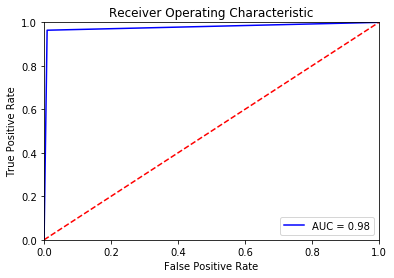

In [10]:
#Train optimized random forest
model7 = RandomForestClassifier(n_estimators=2000 ,
                                min_samples_split= 93,
                                min_samples_leaf=5,
                                bootstrap = False,
                                criterion = 'entropy',
                                max_depth = 14,
                                max_features = 4,
                                n_jobs=-1,
                                random_state=100)
model7.fit(X_train, Y_train)
print('train accuracy: '+str(jaccard_similarity_score(model7.predict(X_train), Y_train)))
print('test accuracy: '+str(jaccard_similarity_score(model7.predict(X_test), Y_test)))

# create roc curve
probs = model7.predict(X_test)
preds = probs
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random forest global feature importance
Find the most important features in the whole dataset (including train and test set)

Feature ranking:
1. feature 2 (0.243857)
2. feature 11 (0.179673)
3. feature 1 (0.114778)
4. feature 7 (0.106491)
5. feature 6 (0.073215)
6. feature 12 (0.046578)
7. feature 9 (0.046085)
8. feature 4 (0.036696)
9. feature 13 (0.036014)
10. feature 8 (0.035481)
11. feature 5 (0.034936)
12. feature 10 (0.030971)
13. feature 0 (0.008573)
14. feature 3 (0.006651)


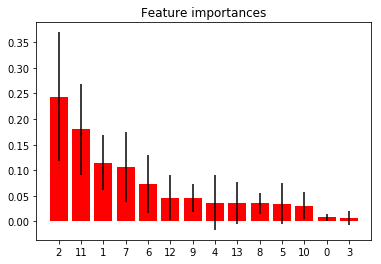

In [43]:
#
importances = model7.feature_importances_
std = np.std([tree.feature_importances_ for tree in model7.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]), indices)
plt.xlim([-1, data.shape[1]])
plt.show()

### Get contributing features in a (RF) signle prediction

In [47]:
import eli5
#eli5.show_prediction(model7, selected_example, feature_names=list(data))
eli5.explain_prediction(model7, selected_example, feature_names=list(data))

Explanation(estimator="RandomForestClassifier(bootstrap=False, class_weight=None,\n            criterion='entropy', max_depth=14, max_features=4,\n            max_leaf_nodes=None, min_impurity_decrease=0.0,\n            min_impurity_split=None, min_samples_leaf=5,\n            min_samples_split=93, min_weight_fraction_leaf=0.0,\n            n_estimators=2000, n_jobs=-1, oob_score=False,\n            random_state=100, verbose=0, warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.37279880104907476, std=None, value=1.0), FeatureWeight(feature='Evergreen Broadleaf Forest', weight=0.3191515327928116, std=None, value=0.3877551020408163), FeatureWeight(feature='Cropland', weight=0.08184729779843755, std=None, value=0.05215419501133787), FeatureWeight(feature='Evergreen Needleleaf Forest', weight=0.063346563763648, std=None, value=0.0), FeatureWeight(feature='Woodland', weight=0.05867420394617237, std=None, value=0.3129251700680272), FeatureWeight(feature='Deciduous Broadleaf Forest', weight=0.05415990779396361, std=None, value=0.2199546485260771), FeatureWeight(feature='Mixed Forest', weight=0.031952630062494256, std=None, value=0.0), FeatureWeight(feature='Urban and Built', weight=0.015715070705710082, std=None, value=0.0), FeatureWeight(feature='Open Shrubland', weight=0.014613215495386123, std=None, value=0.0), FeatureWeight(feature='Bare Ground', weight=0.013169176054721241, std=None, value=0.0), FeatureWeight(feature='Grassland', weight=0.007875995979720432, std=None, value=0.018140589569160998), FeatureWeight(feature='Closed Shrubland', weight=0.003120870834758435, std=None, value=0.009070294784580499), FeatureWeight(feature='Deciduous Needleleaf Forest', weight=0.0029155633026382035, std=None, value=0.0)], neg=[FeatureWeight(feature='Wooded Grassland', weight=-0.035686372493119074, std=None, value=0.0), FeatureWeight(feature='Water', weight=-0.004328570928038686, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=0.9993258861583822, score=None, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)